In [136]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statistics as stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from collections import Counter
import itertools
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Classifying Breast Cancer Subtype with transcriptomics data

- This project goal is to use the Cancer Genome Atlas (TCGA) data on Breast cancer patients to classify Breast Cancer subtypes using gene expression (transcriptomics) data. This is a multiclass classfication problem because there are 5 main subtypes of breast cancer. I hope to use unsupervised machine learning model for this project.

- Background: Breast Cancer is a heterogeneous diseases, meaning there are multiple subtypes of breast cancer with different pathological properties. Breast Cancer tumors can be classified into 5 main subtypes: Luminal A, Luminal B, HER2-enriched, Basal-like, and Normal-like. Knowing patients' cancer subtype is important to determine the course of treatment and appropriate therapy. Some subtypes are considered more aggressive and need urgent removal surgery and chemo therapy combined. However, some other types of breast cancers are less agressive and can be responsive to noninvasive hormone therapy.

- Because it is important to identify breast cancer subtypes, scientists studying molecular biology have come up with a list of 50 genes that are unique to each subtype. This list is call PAM50, which contains major cancer biomarkers for breast cancer.

- I hope to use the gene expression of PAM50 genes to train unsupervised models to classify breast cancer subtype with high accuracy. I hope that my model could offer an alternative tool to traditional immunohistochemtry classification.

- The results here are in whole or part based upon data generated by the TCGA Research Network: https://www.cancer.gov/tcga. Data was downloaded using cBioPortal (citation below)

Cerami et al. The cBio Cancer Genomics Portal: An Open Platform for Exploring Multidimensional Cancer Genomics Data. Cancer Discovery. May 2012 2; 401. PubMed.

# Import data

There are 3 documents downloaded from TCGA for this project.

First, let's import the clinical data on the patients. 

This dataframe has 38 different columns and 1084 patients.

The 38 columns contains different clinical information on the patients such as cancer subtype, age, sex, tumor stages, etc.

For this project, I'm only interested in the breast cancer subtypes, so I'm only selecting subtype and patient ID columns

In [140]:
label = pd.read_table("data_clinical_patient.txt", delimiter="	")
label.shape

(1084, 38)

In [141]:
label.head()

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
0,TCGA-3C-AAAU,BRCA_LumA,BRCA,6E7D5EC6-A469-467C-B748-237353C23416,55,Female,STAGE X,6TH,4047.0,-20211.0,...,Yes,0:LIVING,133.050597,0:ALIVE OR DEAD TUMOR FREE,133.050597,1:Recurred/Progressed,59.440444,1:PROGRESSION,59.440444,EUR
1,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,Yes,0:LIVING,131.669790,0:ALIVE OR DEAD TUMOR FREE,131.669790,0:DiseaseFree,131.669790,0:CENSORED,131.669790,AFR
2,TCGA-3C-AALJ,BRCA_LumB,BRCA,427D0648-3F77-4FFC-B52C-89855426D647,62,Female,STAGE IIB,7TH,1474.0,-22848.0,...,Yes,0:LIVING,48.459743,0:ALIVE OR DEAD TUMOR FREE,48.459743,0:DiseaseFree,48.459743,0:CENSORED,48.459743,AFR_ADMIX
3,TCGA-3C-AALK,BRCA_LumA,BRCA,C31900A4-5DCD-4022-97AC-638E86E889E4,52,Female,STAGE IA,7TH,1448.0,-19074.0,...,Yes,0:LIVING,47.604958,0:ALIVE OR DEAD TUMOR FREE,47.604958,NaN,NaN,0:CENSORED,47.604958,AFR
4,TCGA-4H-AAAK,BRCA_LumA,BRCA,6623FC5E-00BE-4476-967A-CBD55F676EA6,50,Female,STAGE IIIA,7TH,348.0,-18371.0,...,Yes,0:LIVING,11.440971,0:ALIVE OR DEAD TUMOR FREE,11.440971,0:DiseaseFree,11.440971,0:CENSORED,11.440971,EUR


Next, let's import the gene expression data. This is a large table with 1084 columns and 20531 rows.

Each column corresponds to a patient (except for the first 2 columns on the gene names)

Each row contains the information on gene expression of a gene.

In [142]:
df = pd.read_table("data_mrna_seq_v2_rsem.txt", delimiter="	")
df.shape

(20531, 1084)

In [143]:
df.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,NaN,100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,1.4644,15.3396,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
2,UBE2Q2P2,100134869,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,8.9958,14.3935,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
3,HMGB1P1,10357,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,107.5630,116.3870,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
4,NaN,10431,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1420.5000,657.2810,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700


# Data Cleaning

For this project, I'm only interested in classifying cancer subtype. So I'm selecting only the patient ID and subtype columns from the label data frame.

There are 103 null values in the patient subtype. This is a relatively small number of patients compared to the whole dataset. Therefore, I will remove the missing values.

In [144]:
# Select Columns of label
label=label[["PATIENT_ID","SUBTYPE"]]
label.info()

# Inspect Subtype column for null value
label.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PATIENT_ID  1084 non-null   object
 1   SUBTYPE     981 non-null    object
dtypes: object(2)
memory usage: 17.1+ KB


PATIENT_ID      0
SUBTYPE       103
dtype: int64

In [145]:
# Remove null values
label=label.dropna()

label.shape

(981, 2)

After removing missing values, let's see how many patients are in each subtype.

I notice that the number of patient from the normal like subtype is very small. This could cause my models to not be able to predict this category well. Therefore, I will remove this subtype from our dataset for now.

In [146]:
Counter(label.SUBTYPE)

Counter({'BRCA_LumA': 499,
         'BRCA_Her2': 78,
         'BRCA_LumB': 197,
         'BRCA_Normal': 36,
         'BRCA_Basal': 171})

In [147]:
# Remove Normal like Breast Cancer
label=label[label.SUBTYPE!="BRCA_Normal"]

label.shape

(945, 2)

I also notice that there is unecessary prefix in subtype labels. All of the label starts with 'brca_'.
So I will remove this unecessary prefix.

In [148]:
# Remove the unecessary prefix BRCA in label.
label.SUBTYPE=[i[5:] for i in label.SUBTYPE]
Counter(label.SUBTYPE)

Counter({'LumA': 499, 'Her2': 78, 'LumB': 197, 'Basal': 171})

Next, I will import the list of PAM 50 genes. We see that the list contains Gene Symbol.

In [149]:
# Import PAM 50 gene list
PAM50 = pd.read_csv("PAM50.csv")
PAM50.head()

,Gene_Symbol
0,ACTR3B
1,ANLN
2,BAG1
3,BCL2
4,BIRC5


For this project, I will select only gene expression data from our PAM 50 list.

After this selection, we see that the gene expression data frame has 50 rows and 1084 columns.

In [150]:
# Select PAM50 genes from the gene expression data
df=df[df.Hugo_Symbol.isin(list(PAM50.Gene_Symbol))]

df.shape

(50, 1084)

Next, I will reformat the gene expression data for model fitting.

I will transpose the data frame so that each row is a different patient and the columns are the 50 genes.

After that, I will select only patients that we have subtype labels of. We see that the reformatted data frame has 945 patients and 50 rows.

This is the same number of rows as the label list.

In [151]:
# Transpose expression data
df=df.T

#Rename the columns as gene symbol
df.columns = df.iloc[0].values

#Change the patient ID to the same format as the label patient ID (Remove the last 3 digits)
df=df.set_axis([i[:len(i)-3] for i in df.index.values], axis=0)

#Select Patient samples in our label list
df=df[df.index.isin(list(label.PATIENT_ID))]

print(df.shape)
df.head()

(945, 50)


,ACTR3B,ANLN,BAG1,BCL2,BIRC5,BLVRA,CCNB1,CCNE1,CDC20,CDC6,...,PGR,PHGDH,PTTG1,RRM2,SFRP1,SLC39A6,TMEM45B,TYMS,UBE2C,UBE2T
TCGA-3C-AAAU,359.824,828.215,1890.57,2315.76,390.798,850.618,1282.82,163.368,603.153,488.037,...,2273.27,741.361,383.605,1477.21,473.217,90765.9,2.4126,493.114,555.59,318.465
TCGA-3C-AALI,144.644,1566.07,728.026,264.818,859.494,1873.3,1877.65,227.841,648.722,553.018,...,27.1887,759.652,553.018,3219.14,101.686,1699.29,799.347,719.32,1351.28,1004.35
TCGA-3C-AALJ,153.219,637.353,1869.72,2538.53,744.461,2153.22,1822.3,178.604,873.98,925.657,...,473.835,106.981,802.357,1305.53,67.0898,15816.9,5.4397,667.017,1195.83,757.026
TCGA-3C-AALK,135.292,631.775,1651.16,2172.11,522.019,1327.27,827.058,44.2698,539.098,183.285,...,2236.46,694.663,311.957,909.392,1236.66,19032.7,532.478,724.692,496.897,373.19
TCGA-4H-AAAK,235.319,359.575,2154.5,1575.32,202.962,651.064,647.66,56.5957,389.362,399.575,...,4425.19,626.383,257.872,384.255,1531.91,3834.89,385.106,675.723,322.128,192.34


In [152]:
#Inspect for missing values in the expression data
df.isnull().sum()

ACTR3B     0
ANLN       0
BAG1       0
BCL2       0
BIRC5      0
BLVRA      0
CCNB1      0
CCNE1      0
CDC20      0
CDC6       0
CDH3       0
CENPF      0
CEP55      0
CXXC5      0
EGFR       0
ERBB2      0
ESR1       0
EXO1       0
FGFR4      0
FOXA1      0
FOXC1      0
GPR160     0
GRB7       0
KIF2C      0
KRT14      0
KRT17      0
KRT5       0
MAPT       0
MDM2       0
MELK       0
MIA        0
MKI67      0
MLPH       0
MMP11      0
MYBL2      0
MYC        0
NAT1       0
NDC80      0
NUF2       0
ORC6L      0
PGR        0
PHGDH      0
PTTG1      0
RRM2       0
SFRP1      0
SLC39A6    0
TMEM45B    0
TYMS       0
UBE2C      0
UBE2T      0
dtype: int64

There is no missing data in the gene expression data set. This is great.

However, the gene expression data set is currently stored as string. Therefore, I will change the data type to float.

In [153]:
#Inspect Data type of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 945 entries, TCGA-3C-AAAU to TCGA-Z7-A8R6
Data columns (total 50 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ACTR3B   945 non-null    object
 1   ANLN     945 non-null    object
 2   BAG1     945 non-null    object
 3   BCL2     945 non-null    object
 4   BIRC5    945 non-null    object
 5   BLVRA    945 non-null    object
 6   CCNB1    945 non-null    object
 7   CCNE1    945 non-null    object
 8   CDC20    945 non-null    object
 9   CDC6     945 non-null    object
 10  CDH3     945 non-null    object
 11  CENPF    945 non-null    object
 12  CEP55    945 non-null    object
 13  CXXC5    945 non-null    object
 14  EGFR     945 non-null    object
 15  ERBB2    945 non-null    object
 16  ESR1     945 non-null    object
 17  EXO1     945 non-null    object
 18  FGFR4    945 non-null    object
 19  FOXA1    945 non-null    object
 20  FOXC1    945 non-null    object
 21  GPR160   945 non-null   

In [154]:
#Change data type of expression to float
df=df.astype(float)

In [155]:
df.describe()

,ACTR3B,ANLN,BAG1,BCL2,BIRC5,BLVRA,CCNB1,CCNE1,CDC20,CDC6,...,PGR,PHGDH,PTTG1,RRM2,SFRP1,SLC39A6,TMEM45B,TYMS,UBE2C,UBE2T
count,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,275.846050,1012.823805,1952.754977,1890.358399,524.996990,1451.507104,1137.119337,183.569861,864.703608,669.128613,...,3158.040547,1885.704925,499.952742,1240.593250,3311.926235,27516.900102,288.084256,779.138844,828.126413,503.813989
std,282.445983,994.193998,1717.198214,1716.657501,604.095206,905.342780,727.787416,418.525123,917.008176,1301.794728,...,5803.365412,5460.554472,459.977175,1157.119445,7886.030361,37564.312748,486.737467,752.199525,861.447353,390.688126
min,11.552000,21.292600,230.587000,31.986500,2.755500,31.000900,118.223000,7.737500,10.270500,13.527100,...,1.531900,9.178500,25.457400,4.759500,0.917900,440.568000,0.000000,57.681800,7.014000,34.471200
25%,146.097000,382.712000,1068.080000,591.842000,168.045000,831.486000,609.710000,36.153100,288.462000,215.969000,...,58.007300,375.672000,212.581000,509.994000,150.646000,4663.140000,39.618900,347.465000,268.693000,229.679000
50%,197.791000,700.401000,1509.710000,1509.930000,332.623000,1276.850000,962.478000,67.767900,527.678000,408.541000,...,810.727000,789.369000,367.396000,930.021000,602.437000,12931.300000,138.095000,568.174000,570.377000,402.128000
75%,275.960000,1283.490000,2236.350000,2684.460000,679.231000,1842.770000,1504.650000,152.640000,1074.200000,691.622000,...,3945.000000,1811.540000,625.101000,1623.450000,2775.680000,34433.700000,321.365000,949.784000,1096.580000,664.545000
max,3093.820000,9441.640000,21058.200000,12810.900000,8099.990000,11028.500000,5048.520000,7414.170000,8140.810000,17689.300000,...,91369.500000,131485.000000,4268.610000,14223.500000,107598.000000,430927.000000,5437.160000,7120.590000,9802.470000,3963.540000


After data cleaning, I think the gene expression data looks good with no missing values.

# Exploratory Data Analysis

## Visualize the data label

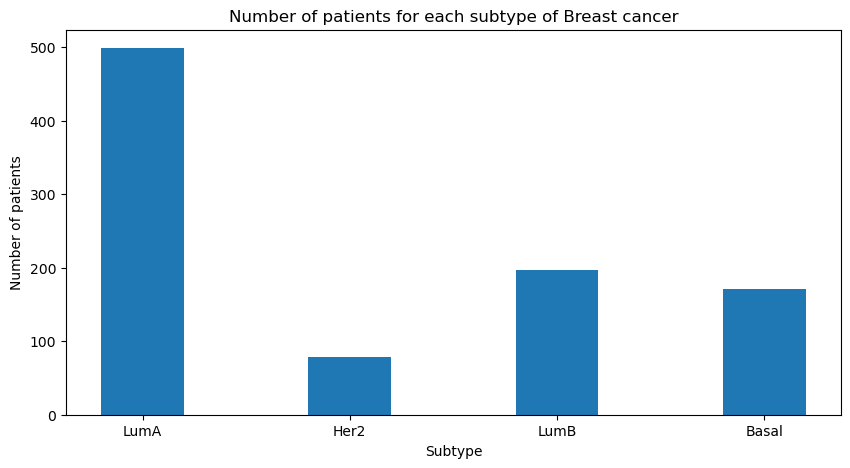

In [156]:
# Plot number of patients in each group
subtype_count=Counter(label.SUBTYPE)
subtype=list(subtype_count.keys())
counts=list(subtype_count.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(subtype, counts, width = 0.4)

plt.xlabel("Subtype")
plt.ylabel("Number of patients")
plt.title("Number of patients for each subtype of Breast cancer")
plt.show()

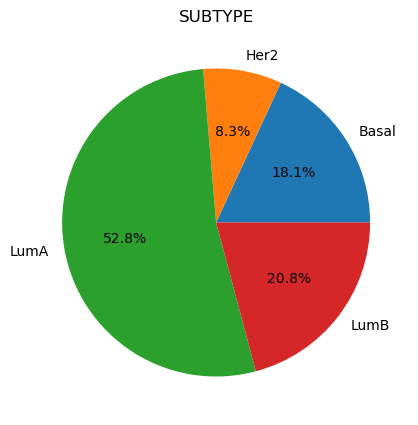

In [157]:
#Pie chart
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
t = label.groupby(["SUBTYPE"]).size()
axes.pie(t, labels=t.index.values, autopct='%1.1f%%')
axes.set_title("SUBTYPE")
plt.show()

From the bar chart and the pie chart of the subtypes, I notice that more than 50% of the patients in our dataset have Luminal A subtype.

This is consistent with other population studies, which showed that Luminal A is the most common subtype of breast cancer, accounting for 50-60% of all breast cancers. 

This suggests that our data is reflective of the population, thus increasing the relevance of this project.

Her2 and Basal are less common types of breast cancer. These are also the more agressive subtypes. It is also shown here that her2 and basal have the lowest number of patients in my data set.

Overall, my data resembles the populational data on breast cancer subtypes. However, due to the low number of her2 patients(8%), my future models can have a hardtime separating those patients from other subtypes. This is something to consider when fitting the models.

## Visualize gene expression data

Below is the histograms of 4 random genes in the 50 gene list. 

I will explain more about the number. The number for each gene is called gene counts. This is the number of sequencing reads mapped to specifc genes. The concept is the more number of reads (gene counts), the more abudant a specific mRNA is. This is the standard values for gene expression data set.

The gene counts are normalized to the sample total count. This prevents the size of the sample from affecting the analysis.

After plotting the histograms, we see that the gene counts follow a poisson distribution. This makes sense because it's basically count data. The range of the gene counts are also very large.

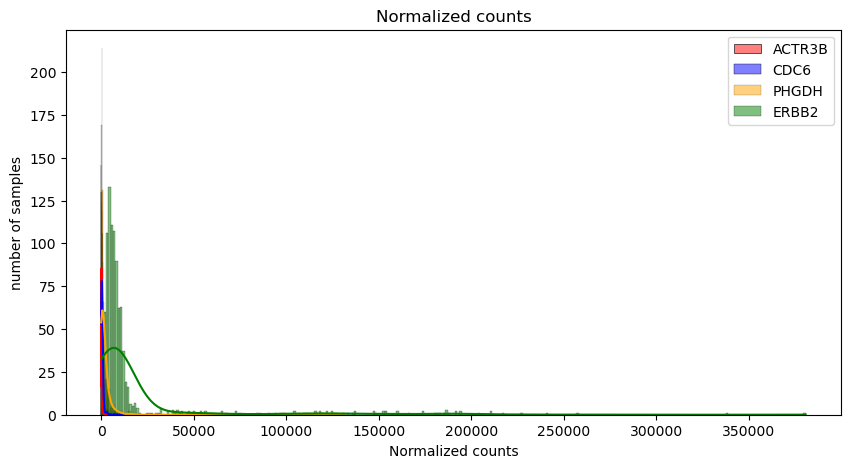

In [158]:
plt.figure(figsize=(10, 5))

sns.histplot(df, x='ACTR3B', color="red", label="ACTR3B",kde=True)
sns.histplot(df, x='CDC6', color="blue", label="CDC6",kde=True)
sns.histplot(df, x='PHGDH', color="orange", label="PHGDH",kde=True)
sns.histplot(df, x='ERBB2', color="green", label="ERBB2",kde=True)
plt.legend()
plt.xlabel('Normalized counts')
plt.ylabel('number of samples')
plt.title("Normalized counts")
plt.show()

### Log2 Transform
The normalized gene counts follow a poisson distribution and has a large range. This could cause problems when fitting models because a lot of models have an underlying assumption that the feature data is normally distributed.

The large range of gene count can also reduce machine learning model performance because it can overly emphasize the important of genes with large counts.

To solve this problem, I will Log2 transform the count data. Because some of the count values are 0, I will add 1 to all values before transforming to prevent the Log2 to be infinity. 

After Log transformation, we see that gene expression follows a normal distribution and the range of data is reduced significantly.

In [159]:
# Log2 transform count data
df_transformed=np.log2(df+1)

df_transformed.describe()

,ACTR3B,ANLN,BAG1,BCL2,BIRC5,BLVRA,CCNB1,CCNE1,CDC20,CDC6,...,PGR,PHGDH,PTTG1,RRM2,SFRP1,SLC39A6,TMEM45B,TYMS,UBE2C,UBE2T
count,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,7.759274,9.417459,10.636780,10.205400,8.342626,10.237893,9.868384,6.379727,9.095328,8.631772,...,9.005069,9.699513,8.485462,9.765456,9.289548,13.672925,6.694694,9.178919,9.049445,8.591177
std,0.904834,1.337914,0.859375,1.584678,1.487076,0.924908,0.932593,1.623998,1.422526,1.335297,...,3.450402,1.762718,1.210365,1.291436,2.856932,1.837188,2.394672,1.089250,1.455761,1.097084
min,3.649845,4.478493,7.855410,5.043804,1.909005,5.000041,6.897519,3.127221,3.494480,3.860675,...,1.340220,3.347453,4.725599,2.525944,0.939527,8.786492,0.000000,5.874841,3.002523,5.148576
25%,7.200624,8.583880,10.062154,9.211504,7.401264,9.701282,9.254344,5.215411,8.177230,7.761345,...,5.882822,8.557165,7.738640,8.997163,7.244564,12.187395,5.344079,8.444870,8.075174,7.849743
50%,7.635109,9.454096,10.561011,10.561221,8.382075,10.319503,9.912108,6.103663,9.046245,8.677864,...,9.664851,9.626383,8.525114,9.862670,9.237059,13.658691,7.119927,9.152726,9.158299,8.655094
75%,8.113534,10.326980,11.127575,11.390954,9.409881,10.848443,10.556171,7.263410,10.070389,9.435924,...,11.946175,10.823797,9.290252,10.665736,11.439145,15.071575,8.332551,9.892974,10.100110,9.378392
max,11.595640,13.204975,14.362163,13.645197,12.983883,13.429080,12.301931,12.856264,12.991134,14.110671,...,16.479441,17.004550,12.059889,13.796090,16.715305,18.717087,12.408903,12.797984,13.259077,11.952938


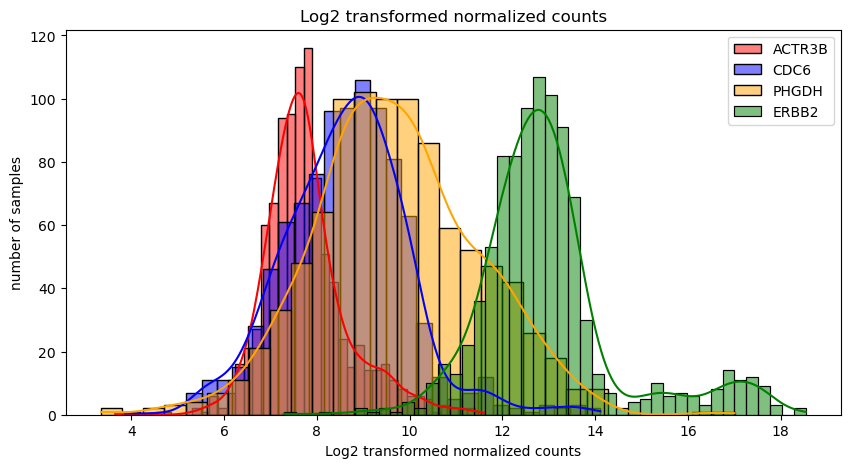

In [160]:
#Inspect expression histogram after log transformation
plt.figure(figsize=(10, 5))

sns.histplot(df_transformed, x='ACTR3B', color="red", label="ACTR3B",kde=True)
sns.histplot(df_transformed, x='CDC6', color="blue", label="CDC6",kde=True)
sns.histplot(df_transformed, x='PHGDH', color="orange", label="PHGDH",kde=True)
sns.histplot(df_transformed, x='ERBB2', color="green", label="ERBB2",kde=True)
plt.legend()
plt.xlabel('Log2 transformed normalized counts')
plt.ylabel('number of samples')
plt.title("Log2 transformed normalized counts")
plt.show()

## Principal Component Analysis (PCA)

To visualize the variance in gene expression data of different subtypes, I perform PCA and plot the first and second PC.

We see that the data in the same subtype are well clustered together. We see a big difference of Basal from the rest of the subtypes. This makes sense biologically because basal subtype (also called triple negative) does not response to hormone or her2. On the other hand her2, luminal A and B are closer to each other in the PCA, suggesting similar molecular information.

From the PCA plot, I think that models will have an easier time differentiating Basal tumors from other subtypes, However, models might not be able to classify her2, lumA and lumB accurately. This has to do with the biology behind this data, not because of model design.



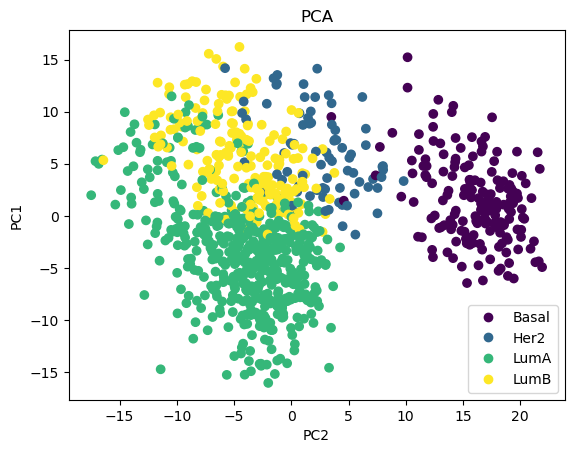

In [297]:
# PCA plot of samples
X=df_transformed.to_numpy()
y=label.SUBTYPE

pca = PCA()
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=pd.Categorical(y).codes)
plt.legend(handles=plot.legend_elements()[0], labels=["Basal","Her2","LumA","LumB"])
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title("PCA")
plt.show()

## Correlation Matrix

I will combine the lable and gene expression to create a correlation matrix.

From this matrix, I can inspect the features relationship with each other.

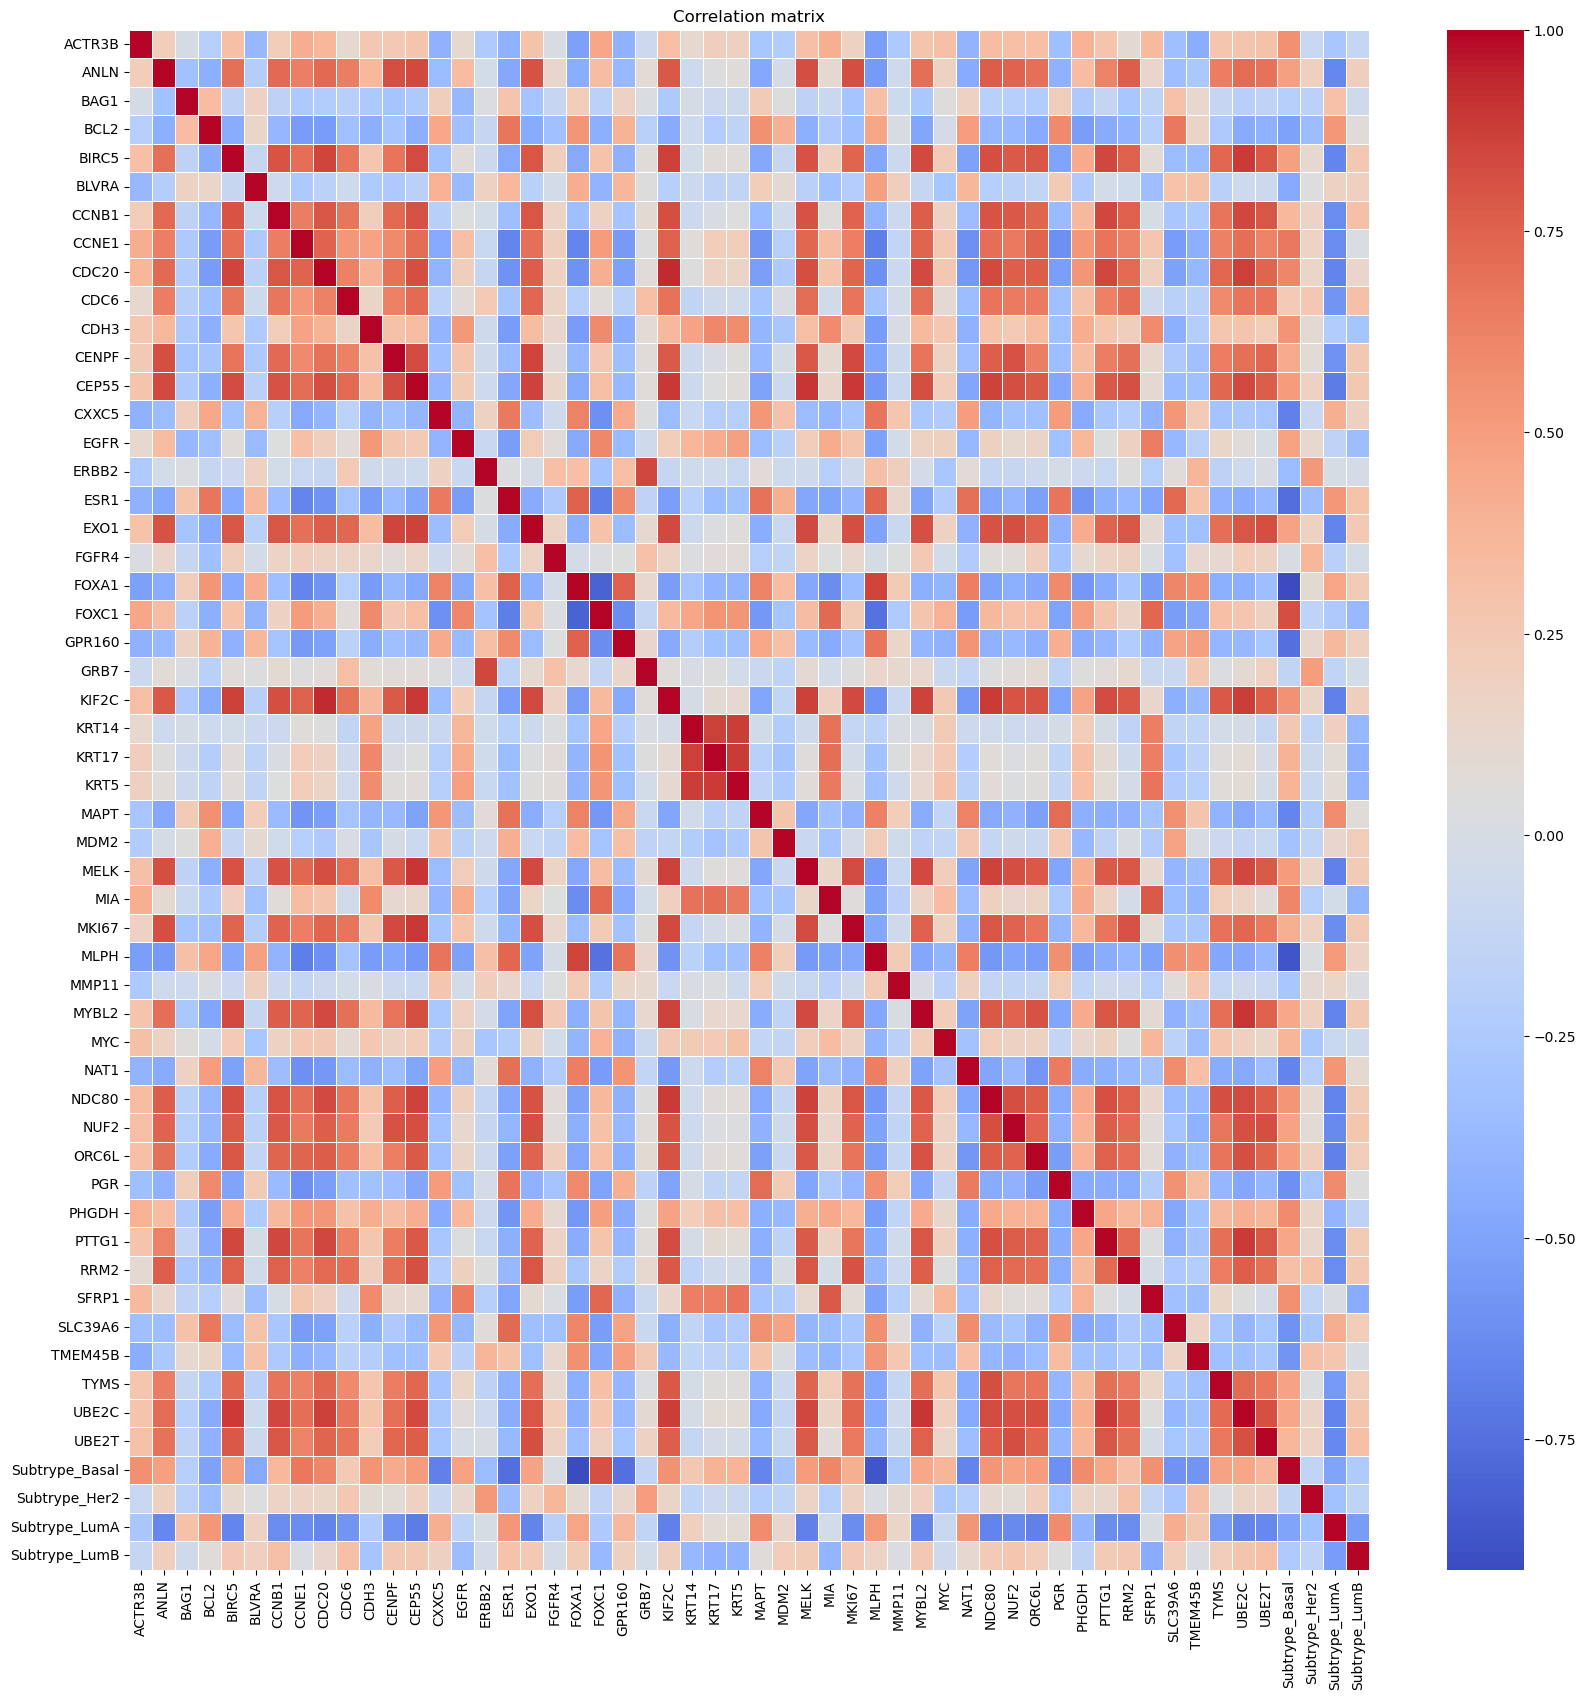

In [162]:
# Combine subtype to expression data to create correlation matrix
df_transformed_corr=df_transformed.copy()
df_transformed_corr.insert(0, "Subtrype", np.array(label.SUBTYPE), True)
df_transformed_corr=pd.get_dummies(df_transformed_corr)

# Corraltion matrix between genes
corr_mat = df_transformed_corr.corr()

# Building a heat map of the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

### Dicussion
From the matrix correlation, I notice that most of the genes from the PAM50 list has a strong correlation with the subtype. An example would be ERBB2 (HER2) gene is positively correlated with her2 subtype. This is intuitively expected because the biological marker of her2 subtype is an increased in HER2 expression. 

I notice that a lot of genes are correlated with each other. This is also expected because these genes are the signature for breast cancer development. A lot of these genes are involved in the same biological pathways, so they should be correlated. 

These correlations is not concerning because my unsupervised models are not affected by collinearity. Therefore, I can proceed to train the models with this gene expression data.

# Unsupervised Machine Learning Models

## Hierarchical clustering

First, I will train a hierarchical clustering model with our data. I selected this model because it is appropriate for classification tasks. The model can group data points together based on their similarity or distance from each other.

Because the unsupervised models don't use label when training, it is important to permute through the label to find the order that gives the highest accuracy. This is the function to permute through the prediction values of models and find the best match with highest accuracy.

I also wrote custom score functions for later hyperparameter tuning.

In [224]:
def label_permute_compare(ytrue,yp,n=4):
    # Get unique labels of array
    labels=np.unique(ytrue)
    List=[]
    for i in itertools.permutations(range(n)):
        ytrue_copy=np.copy(ytrue)
        for j in range(n):
            ytrue_copy[ytrue_copy == labels[j]] = i[j]
        ytrue_copy=ytrue_copy.astype(int)
        acc=accuracy_score(ytrue_copy, yp)
        List.append((i,acc))
    acc=sorted(List, key=lambda x: x[1],reverse=True)[0]
    return acc

def custom_score_HC(model, X, y):
    return label_permute_compare(y, model.fit(X).labels_)[1]

def custom_score_NMF(model, X, y):
    W = model.transform(X)
    pred = np.argmax(W, axis=1)
    return label_permute_compare(y, pred)[1]

I will fit an initial HC model with 4 clusters because there are 4 different subtypes

In [167]:
# Initial hierarchical clustering
HC = AgglomerativeClustering(n_clusters=4,linkage='ward').fit(df_transformed)

#Get predictions
labelorder, acc = label_permute_compare(label.SUBTYPE, HC.labels_)
print(labelorder, acc)

(1, 3, 0, 2) 0.782010582010582


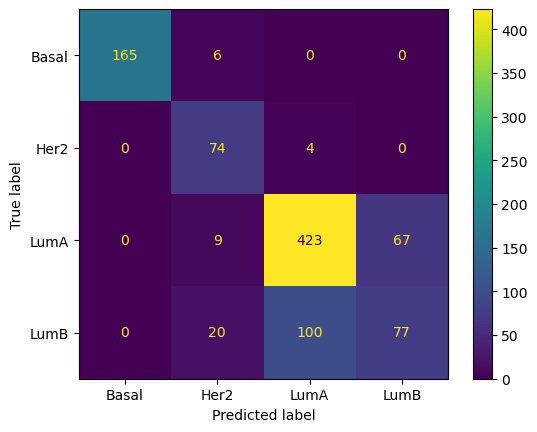

In [168]:
# Show confusion matrix
y_true=np.array(label.SUBTYPE)
y_pred= HC.labels_.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

The initial model shows a pretty good accuracy score of 0.78.

### Hyperparametering tuning

I will fit the model with different combinations of parameters to find the best performing model.

I will use GridCV for this. The parameters include metric (affinity) and linkage.



In [204]:
#Hyperparameter tuning
param = [{ 'n_clusters': [4],
    'affinity': ['l1', 'l2', 'manhattan', 'cosine','euclidean'],
    'linkage': ['complete', 'average', 'single']},
        {'n_clusters': [4],
        'affinity': ['euclidean'],
        'linkage': ['ward']}]

HC = AgglomerativeClustering()

grid_search_HC = GridSearchCV(HC, param, scoring=custom_score_HC, cv = [(slice(None), slice(None))])
grid_search_HC.fit(df_transformed, label.SUBTYPE)

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=AgglomerativeClustering(),
             param_grid=[{'affinity': ['l1', 'l2', 'manhattan', 'cosine',
                                       'euclidean'],
                          'linkage': ['complete', 'average', 'single'],
                          'n_clusters': [4]},
                         {'affinity': ['euclidean'], 'linkage': ['ward'],
                          'n_clusters': [4]}],
             scoring=<function custom_score_HC at 0x7f82106c6050>)

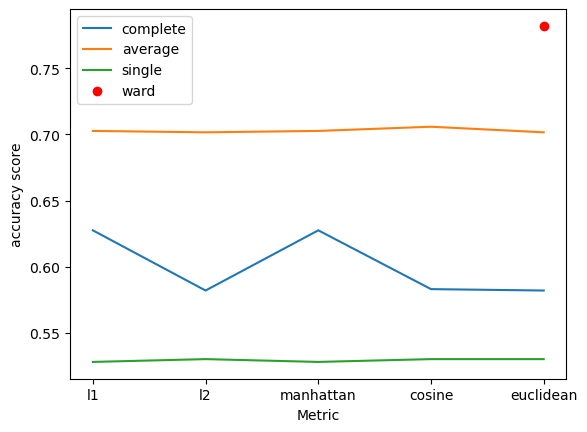

Best parameters: 
{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 4}


In [207]:
HC_res=pd.DataFrame(grid_search_HC.cv_results_)

plt.plot(['l1', 'l2', 'manhattan', 'cosine','euclidean'], np.array(HC_res[HC_res.param_linkage=="complete"].mean_test_score), label = "complete") 
plt.plot(['l1', 'l2', 'manhattan', 'cosine','euclidean'], np.array(HC_res[HC_res.param_linkage=="average"].mean_test_score), label = "average")
plt.plot(['l1', 'l2', 'manhattan', 'cosine','euclidean'], np.array(HC_res[HC_res.param_linkage=="single"].mean_test_score), label = "single")
plt.plot('euclidean', HC_res[HC_res.param_linkage=="ward"].mean_test_score,'ro', label = "ward") 
plt.legend()
plt.xlabel('Metric') 
plt.ylabel('accuracy score') 
plt.show()

print("Best parameters: ")
print(grid_search_HC.best_params_)


In [270]:
# Refit best Hierarchical clustering with the best parameters
HC_final = AgglomerativeClustering(n_clusters=4,linkage='ward',affinity='euclidean').fit(df_transformed)

#Get predictions
labelorder, acc_HC = label_permute_compare(label.SUBTYPE, HC_final.labels_)
print(labelorder, acc_HC)

(1, 3, 0, 2) 0.782010582010582


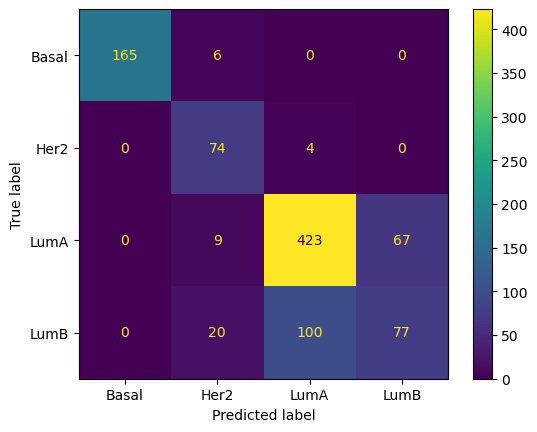

In [271]:
# Show confusion matrix
y_true=np.array(label.SUBTYPE)
y_pred= HC_final.labels_.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

#Macro f1 score
f1_HC=f1_score(y_true, y_pred,average='macro')

We see that the best performing model use euclidean metric with ward linkage. 

The best HC model achieves an accuracy score of 0.78.

The model is able to classify basal tumors correctly. The model misclassifies some Her2, LumA, and LumB tumors. This is expected from my previous EDA. This misclassification is likely due to the similarity of Her2, LumA, and LumB biologically and molecularly.

Overall, the Hierarchical clustering model performs pretty well.

# Kmeans clustering

The next model I will fit is unsupervised Kmeans clustering.

I will also fit an initial model with 4 clusters and perform hyperparamter tuning later on to improve accuracy.

In [298]:
# Initial Kmean clustering
KM=KMeans(n_clusters=4, random_state=21).fit(df_transformed)

#Get predictions
labelorder, acc_KM = label_permute_compare(label.SUBTYPE, KM.labels_)
print(labelorder, acc_KM)

(1, 0, 3, 2) 0.7502645502645503


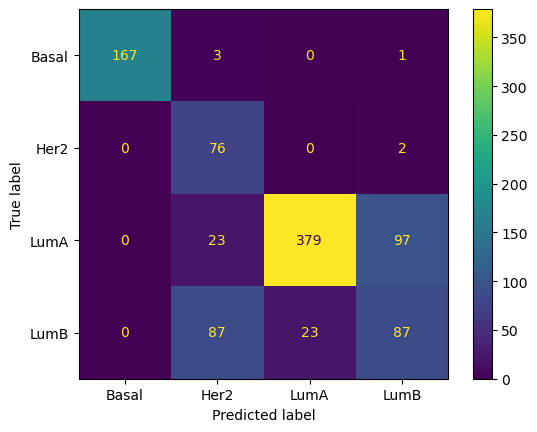

In [299]:
# Show confusion matrix
y_true=np.array(label.SUBTYPE)
y_pred= KM.labels_.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

#Macro f1 score
f1_KM=f1_score(y_true, y_pred,average='macro')

### Hyperparameter tuning

Kmeans clustering doesn't require users to input a lot of hyperparamters. So I will only change the number of maximum iteration for the data to converge. The range would be from 20 to 300

In [222]:
#Hyperparameter tuning
param = { 'n_clusters': [4],
    'max_iter': list(range(20,301,20)),
    'random_state': [21]}

KM = KMeans()

grid_search_KM = GridSearchCV(KM, param, scoring=custom_score_HC, cv = [(slice(None), slice(None))])
grid_search_KM.fit(df_transformed, label.SUBTYPE)

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=KMeans(),
             param_grid={'max_iter': [20, 40, 60, 80, 100, 120, 140, 160, 180,
                                      200, 220, 240, 260, 280, 300],
                         'n_clusters': [4], 'random_state': [21]},
             scoring=<function custom_score_HC at 0x7f82106c6050>)

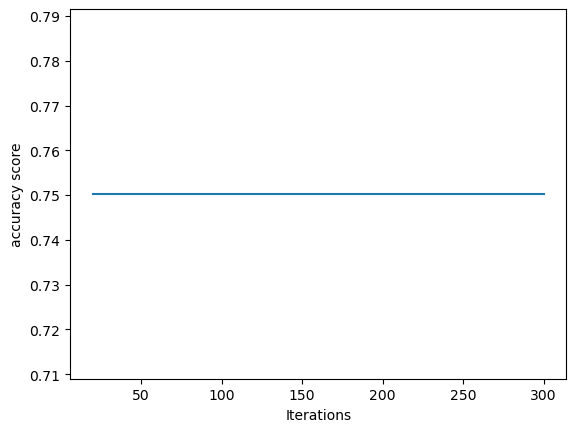

Best parameters: 
{'max_iter': 20, 'n_clusters': 4, 'random_state': 21}


In [223]:
KM_res=pd.DataFrame(grid_search_KM.cv_results_)

plt.plot(list(range(20,301,20)), np.array(KM_res.mean_test_score)) 
plt.xlabel('Iterations') 
plt.ylabel('accuracy score') 
plt.show()

print("Best parameters: ")
print(grid_search_KM.best_params_)


We see that the model's accuracy doesn't change when number of max iterations increases. This suggests that the model converges within less than 20 iterations.

Therefore, the best Kmeans Model is the initial model. This model achieves ana accuracy of 0.75.

The model is able to classify basal tumors correctly. The model misclassifies some Her2, LumA, and LumB tumors. This is expected from my previous EDA. This misclassification is likely due to the similarity of Her2, LumA, and LumB biologically and molecularly.

Overall, the Kmeans clustering model performs pretty well.

# Non Negative Matrix Factorization (NMF)

Finally, I will fit a Non negative matrix factorization model with my data. I will fit an initial model with 4 components and tune the hyperparameters to improve accuracy.

In [173]:
#Fit the model
nmf = NMF(n_components=4, random_state=11)

nmf_output = nmf.fit_transform(df_transformed)

#Get predicted result of train data

nmf_pred=nmf_output.argmax(axis=1)

(0, 2, 1, 3) 0.46984126984126984


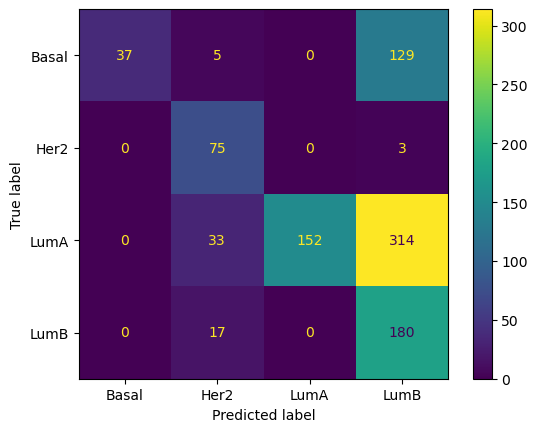

In [174]:
#Get accuracy and label order
labelorder, acc = label_permute_compare(label.SUBTYPE, nmf_pred)
print(labelorder, acc)

# Show confusion matrix
y_true=np.array(label.SUBTYPE)
y_pred= nmf_pred.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

### Hyperparameter tuning

I will try different combination of loss function and solver and max iteration to see which set of parameters yields the highest accuracy.

In [254]:
#Hyperparameter tuning
param = [{ 'n_components': [4],
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'solver': ['mu'],
    'max_iter': list(range(100,501,100))},
         { 'n_components': [4],
    'beta_loss': ['frobenius'],
    'solver': ['cd'],
    'max_iter': list(range(100,501,100))}]

nmf = NMF(random_state=21)

grid_search = GridSearchCV(nmf, param, scoring=custom_score_NMF, cv=[(slice(None), slice(None))])
grid_search.fit(df_transformed, label.SUBTYPE)

/Users/marktran21/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/marktran21/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/marktran21/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=NMF(random_state=21),
             param_grid=[{'beta_loss': ['frobenius', 'kullback-leibler'],
                          'max_iter': [100, 200, 300, 400, 500],
                          'n_components': [4], 'solver': ['mu']},
                         {'beta_loss': ['frobenius'],
                          'max_iter': [100, 200, 300, 400, 500],
                          'n_components': [4], 'solver': ['cd']}],
             scoring=<function custom_score_NMF at 0x7f81e30353f0>)

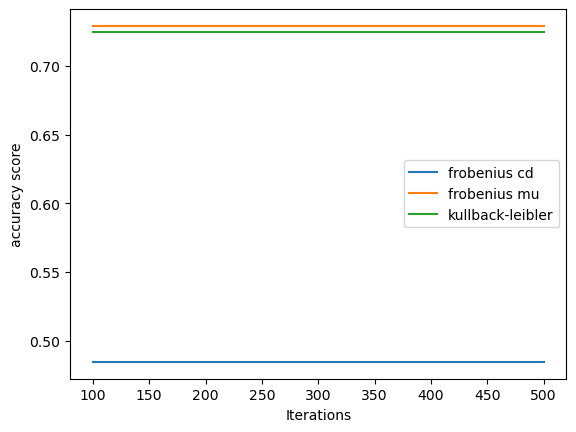

Best parameters: 
{'beta_loss': 'frobenius', 'max_iter': 100, 'n_components': 4, 'solver': 'mu'}


In [255]:
# Plot parameter tuning models
NMF_res=pd.DataFrame(grid_search.cv_results_)

plt.plot(list(range(100,501,100)), np.array(NMF_res[(NMF_res.param_beta_loss=="frobenius") & (NMF_res.param_solver=="cd")].mean_test_score), label = "frobenius cd") 
plt.plot(list(range(100,501,100)), np.array(NMF_res[(NMF_res.param_beta_loss=="frobenius") & (NMF_res.param_solver=="mu")].mean_test_score), label = "frobenius mu") 
plt.plot(list(range(100,501,100)), np.array(NMF_res[NMF_res.param_beta_loss=="kullback-leibler"].mean_test_score), label = "kullback-leibler") 
plt.legend()
plt.xlabel('Iterations') 
plt.ylabel('accuracy score') 
plt.show()

print("Best parameters: ")
print(grid_search.best_params_)


In [262]:
#Fit the final model with best parameters
nmf_final = grid_search.best_estimator_
nmf_output_final = nmf_final.fit_transform(df_transformed)

#Get predicted result of train data
nmf_final_pred=nmf_output_final.argmax(axis=1)

(3, 2, 1, 0) 0.6571428571428571


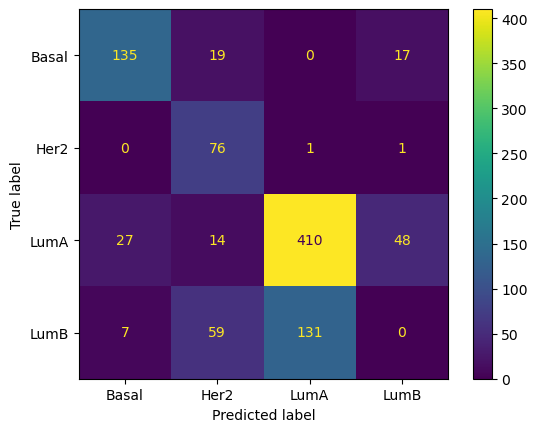

In [275]:
#Get accuracy and label order
labelorder, acc_NMF = label_permute_compare(label.SUBTYPE, nmf_final_pred)
print(labelorder, acc_NMF)

# Show confusion matrix
y_true=np.array(label.SUBTYPE)
y_pred= nmf_final_pred.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

#Macro f1 score
f1_NMF=f1_score(y_true, y_pred,average='macro')

The initial model only has an accuracy of 0.4. However, after hyperparameter tuning, the accuracy of the NMF model icreases to 0.65. The best performing model has frobenius loss function, mu solver, and 100 max iterations.

The highest performing NMR predicts Basal, her2, and LumA with a lot of misclassifications. The model doesn't correctly predict any LumB tumors.

This suggests that the model has a low precision and recall.

Overall, NMF model is not a good model for this data set.

# Comparing Model performance

I will compare the different model performance and select the best performing model out of the 3.

## Accuracy Score

Firsy, let's look at accuracy scores of the models. We see that HC has the highest accuracy score, followed by Kmeans clustering and NMF.

This suggests that HC is the best performing model based on accuracy score. That indicates HC can classify tumors subtype based on the gene expression data more accurately.

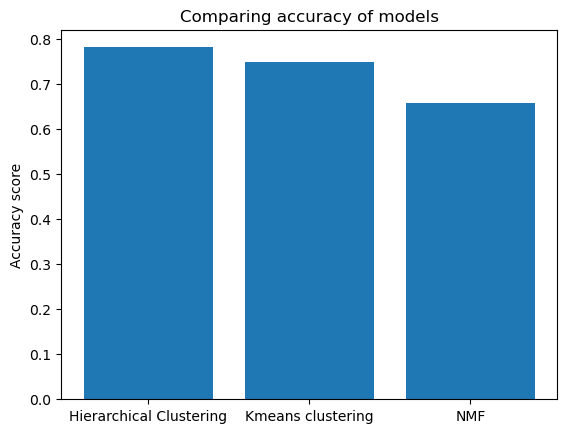

In [277]:
#Plot accuracy score
acc = [acc_HC, acc_KM,acc_NMF]

plt.bar(["Hierarchical Clustering", "Kmeans clustering","NMF"], acc, capsize=5)
plt.ylabel("Accuracy score")
plt.title("Comparing accuracy of models")
plt.show()

## Macro f1 score

Finally, let's look at f1 score. f1 score shows the balance between precision and recall.

My data set is imbalanced in class, in which the number lumA is much greater than other subtypes. F1 Score will capture both precision and recall of the model to see if the model is affected by class imbalance.

Because this is a multiclass classification, I decided to use Macro f1 score to evaluate models. Macro f1 score is calculated by averaging the f1 score for each class classification.

HC model has a highest macro f1 score of 0.75. This is followed by Kmeans Clustering and NMF has the lowest f11 score. 

This suggests that HC can classify tumor subtypes with both high precision and recall. Based on f1 score, HC is also the best performing model.

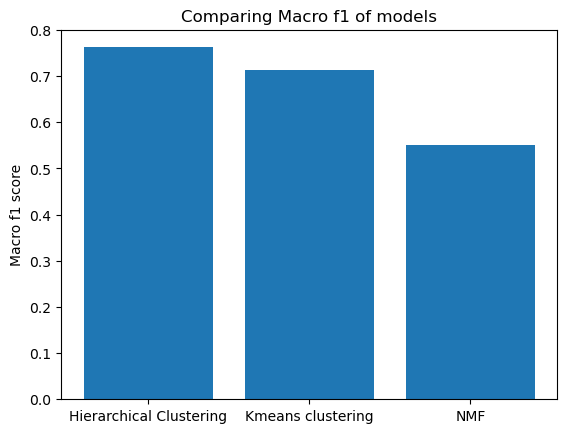

In [300]:
f1 = [f1_HC, f1_KM, f1_NMF]

plt.bar(["Hierarchical Clustering", "Kmeans clustering","NMF"], f1, capsize=5)
plt.ylabel("Macro f1 score")
plt.title("Comparing Macro f1 of models")
plt.show()

# Discussion

- This project aims at solving a classification problem of breast cancer subtypes. The features include PAM50 genes, which are the biomarkers for breast cancers. I inspected and cleaned the data by removing missing values and log transforming gene expression. 

- The data is fitted to 3 different unsupervised classification models: Hierarchical Clustering, Kmeans Clustering, and NMF. Based on the f1 score and accuracy score, the Hierarchical Clustering model is the best performing model with the ability to classify tumor subtypes accurately. Hierarchical Clustering works best with this data set because of its robustness and resistance to overfitting. Therefore, I selected Hierarchical Clustering as my final model to classify tumor subtypes.

- Even though Hierarchical Clustering can predict the best out of the 3 models, the model still misclassify some tumors. I think this is caused by class imbalance in my data. My data has more than 50% tumors from one subtype and the lowest subtype only account for 8% of the data set. This caused the model to spend most of its time learning about the more common subtypes but don't have enough data on other subtypes. Therefore, class imbalance has made my model has a low accuracy.

- To resolve class imbalance, in future project, I can find additional data on less common breast cancer subtypes and up sample my data set. I can also down sample and randomly reduce the number of more common subtypes, so that the proportion between subtypes is closer to 1. I believe that by either up sampling or dowin sampling the data, I can achieve a higher predictive accuracy with my model.